# Time series forecasting with DeepAR - Wikimedia pageview data

- This notebook we train a deepAR model using 2Years/ over a smaller subset (17 projects) of wiki-projects pageview data within requested time range, and test the model with both wiki and synthetic data.  
- Model pipeline: Request to Wiki REST api >> save_jason() to S3 bucket >> train model >> deploy trained model on Sagemaker, create endpoint >> request inference >> get prediction >> evaluation with test metric 

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
#from preprocessor import save_json

In [2]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.6.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [3]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [4]:
bucket = 'sagemaker-deepar20190120'
prefix = 'sagemaker/wiki-test-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Predict setting

We predict the next 48 points of time series.
The time series that we use have hourly granularity.

In [6]:
freq = 'H'
prediction_length = 48

`context_length`: how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`.

In [7]:
context_length = 72

Useful functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3. (didn't call during this example)

In [8]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

### Get wikimedia pageview data from its REST API
We request the http requests sent by users to wiki projects. The output will be a json file with required format, each line contains hourly pageview numbers from `start` to `end`. Output files are saved in a S3 bucket.
- (A side note: wiki api allows 200 requests/s maximum, don't get blacklisted.)
- (Anote side note: the response will be json objects, each has a time stamp and corresponding time series values such as pageview, the maximum number of returned objects is 5000 that's why I use time delta = 200 days = 4800 objects for each request)

In [9]:
import datetime
import requests
import json
import time

all_data = []
project_list = []
delta = datetime.timedelta(days=199)
hour = datetime.timedelta(hours=1)
zero = datetime.timedelta(hours=0)


def save_json(start, end, out_path, input_path):
    s3filesystem = s3fs.S3FileSystem()
    start_date = datetime.datetime.strptime(start, '%Y%m%d')
    end_date = datetime.datetime.strptime(end, '%Y%m%d')
    if (end_date - start_date).days < 0:
        raise Exception('start date should NOT after end date')

    expected_size = ((end_date - start_date).days + 1) * 24

    # provide wiki-project list here!
    with open(input_path) as f:
        projects = f.read().splitlines()

    for item in projects:
        data = get_single_views(item, start_date, end_date)
        if len(data['target']) == expected_size:
            all_data.append(data)
            project_list.append(item)

    # convert all items to JSON and write to a file
    print('saving data')
    print(project_list)
    with open(input_path[:-4] + '-' + str(start) + '-' + str(end) + '_get.txt', 'w') as f:
        for item in project_list:
            f.write("%s\n" % item)
    with s3filesystem.open(out_path, 'w') as outfile:
        outfile.write('\n'.join(json.dumps(i) for i in all_data) + '\n')
    all_data.clear()
    project_list.clear()


def get_single_views(item, start_date, end_date):
    base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/' \
               + item \
               + '/all-access/user/hourly/'
    # dict is used to save JSON of each domain
    data = dict()
    data['start'] = start_date.strftime('%Y-%m-%d') + ' 00:00:00'
    data['target'] = []

    while start_date <= end_date:
        if start_date + delta <= end_date:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + (start_date + delta).strftime('%Y%m%d') + '23'
            end_check = start_date + delta + 23 * hour
        else:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + end_date.strftime('%Y%m%d') + '23'
            end_check = end_date + 23 * hour
        # make a API request here!!!
        response = requests.get(final_url)
        time.sleep(0.05)
        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print("<-----Error---->: " + final_url + str(e))
            break
        print('<-----OK----->' + final_url)  # debug
        output = response.json()
        print('processed data points: ' + str(len(output['items'])))  # debug
        temp = start_date - hour
        for i in output['items']:
            curr = datetime.datetime.strptime(i['timestamp'], '%Y%m%d%H')
            while curr - temp > hour:
                data['target'].append(0)
                temp += hour
            data['target'].append(i['views'])
            temp = curr

        while (end_check - temp) > zero:
            data['target'].append(0)
            temp += hour

        start_date += datetime.timedelta(days=200)

    return data

In [10]:
train_start = '20160101'
train_end = '20180101'
save_json(train_start,train_end,s3_data_path + "/train/train.json", 'wp_full.txt')
test_start = '20180101'
test_end = '20190101'
save_json(test_start,test_end,s3_data_path + "/test/test.json", 'wp_full.txt')

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4770
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4764
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4747
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 3658
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 2656
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 396
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 248
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 862
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 644
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 499
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 355
<-----

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4767
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4758
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4766
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3160
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4491
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points:

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/arz.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/arz.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/as.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/as.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/as.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/as.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4596
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4657
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4669
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3126
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/az.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/az.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be-tarask.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be-tarask.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be-tarask.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be-tarask.wikipedia.org/all-access/user/hourly/2017082300/2018010123
proc

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4785
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4785
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4792
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3164
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bh.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bh.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3167
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4796
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4794
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4796
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3139
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4784
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4789
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4794
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3166
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikinews.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4586
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cbk-zam.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cbk-zam.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cbk-zam.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cdo.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cdo.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cdo.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4119
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 3671
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 3211
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2367
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 480

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4799
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikivoyage.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/diq.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/diq.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/diq.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/diq.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/donate.wikipedia.org/all-access/user/hourly/2016010100/2016071823404 Client Error: No

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4580
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4620
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikiversity.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikiversity.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4753
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4754
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4766
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2017082300/2018010123
processed data points:

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikiversity.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 3126
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2365
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 105
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4737
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4746
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4768
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3158
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gom.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4026
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4246
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4252
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2951
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hak.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hak.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 480

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4790
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4052
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4028
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4344
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2949
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ii.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 2257
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wikinews.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wikinews.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kab.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kab.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kab.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kab.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kbd.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kbd.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 480

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3115
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4798
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kn.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ko.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4796
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ko.wikiversity.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4797
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ko.wikiversity.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ko.wikiversity.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3167
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/koi.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/koi.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points:

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4703
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4708
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4714
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3118
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kv.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4739
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4724
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4743
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3109
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4432
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4488
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4511
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3084
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3155
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4798


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mg.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mg.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mg.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mg.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mg.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 3637
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mg.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 3845
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4673
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3127
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4741
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4710
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4749
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 313

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4605
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4534
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4608
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3115
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4736
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/my.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/my.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/my.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/my.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/my.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 598
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/my.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 629
<-----

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nap.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nap.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nds.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nds.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nds.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nds.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 316

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikinews.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4765
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4798
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3167
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/om.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3033
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4414
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pfl.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pfl.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pfl.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pfl.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pi.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pi.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4226
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4191
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikiversity.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikivoyage.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikivoyage.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikivoyage.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikivoyage.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/qu.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 480

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4797
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3167
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikinews.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4564
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4507
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4151
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4156
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4278
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3027


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4796
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sn.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 2237
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sn.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2484
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/so.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/so.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/so.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/so.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/srn.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/srn.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 480

processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wiktionary.org/all-access/user/hourly/2017020400/2017082223
p

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikinews.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4790
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikinews.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4799
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 3433
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 3126
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 3041
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 1966
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 1652
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4434
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4436
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4401
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 2102
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 2104
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikinews.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikinews.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3164
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4650
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 3100
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 3244
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2244
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4750
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4776
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4752
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.mediawiki.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikidata.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikidata.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikidata.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikidata.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/xal.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 2672
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 1523
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 948
<----

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-yue.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4771
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3951
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 2884
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 2865
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3770
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 2872
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4777
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3977
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4342
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3790
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3904
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points:

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 2012
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 2343
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4718
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3953
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/az.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/az.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikinews.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4648
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikinews.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3915
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4798
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3983
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/br.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3962
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4759
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3980
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4790
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/chy.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/chy.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ckb.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ckb.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cy.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cy.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cy.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4703
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cy.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3950
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cy.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4712
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cy.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3959


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikinews.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4790
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikinews.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikinews.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikinews.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4767
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikinews.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3977
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fy.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3980
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 299
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 635
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4771
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gu.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4797
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gu.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3981
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gv.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gv.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gv.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4558
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gv.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3935


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hr.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hsb.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hsb.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hsb.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4656
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hsb.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3927
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ht.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 48

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ie.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ie.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ie.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3940
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ie.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3647
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ie.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4673
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ie.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3944
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/iu.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3936
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kk.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4591
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kk.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3876
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kl.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kl.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kl.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4647
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kl.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3924
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ks.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3673
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ks.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 226
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ks.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 1024
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ksh.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ksh.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lbe.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lbe.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lez.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lez.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lg.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lg.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lv.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.wikipedia.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.wikipedia.org/all-access/user/hourly/2018010100/2018071923
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.wikimediafoundation.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.wikimediafoundation.org/all-access/user/hourly/2018010100/2018071923
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.wikisource.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/m

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ml.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ml.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ml.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ml.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ml.wikiversity.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ml.wikiversity.org/all-access/user/hourly/2018010100/2018071923
<-----OK----->https://wikime

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/myv.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/myv.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mzn.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mzn.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/na.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/na.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikivoyage.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikivoyage.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nn.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3976
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikiversity.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikiversity.org/all-access/user/hourly/2018010100/2018071923
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/os.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/os.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pa.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimed

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3878
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnt.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnt.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ps.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ps.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ps.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 2062


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikinews.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4758
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikinews.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3967
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sc.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sc.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sc.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3599
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sc.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3348
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/scn.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/scn.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4732
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3954
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sl.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sl.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/srn.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ss.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ss.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ss.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4616
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ss.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3910
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/st.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikinews.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4790
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikinews.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4790
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 2272
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 2789
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4627
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3896
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tt.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3474
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tum.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tum.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3740
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uz.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3905
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ve.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ve.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4780


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/wo.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3447
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/wuu.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/wuu.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikipedia.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikipedia.org/all-access/user/hourly/2018010100/2018071923
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.mediawiki.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimed

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-min-nan.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-min-nan.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3673
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-min-nan.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4443
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-min-nan.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3864
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-yue.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-yue.wikipedia.org/all-access/user/hourly/2018072000/2

### Train a model

In [11]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

In [12]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [13]:
estimator.set_hyperparameters(**hyperparameters)

In [14]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-01-28-05-34-26-468


2019-01-28 05:34:26 Starting - Starting the training job...
2019-01-28 05:34:27 Starting - Launching requested ML instances......
2019-01-28 05:35:28 Starting - Preparing the instances for training...
2019-01-28 05:36:20 Downloading - Downloading input data
2019-01-28 05:36:20 Training - Downloading the training image....
Arguments: train
[01/28/2019 05:37:01 INFO 140018004830016] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[01/28/2019 05:37:01 INFO 140018

[01/28/2019 05:37:22 INFO 140018004830016] Epoch[1] Batch[25] avg_epoch_loss=7.706555
[01/28/2019 05:37:22 INFO 140018004830016] Epoch[1] Batch [25]#011Speed: 172.91 samples/sec#011loss=7.721288
[01/28/2019 05:37:22 INFO 140018004830016] processed a total of 828 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 7023.259878158569, "sum": 7023.259878158569, "min": 7023.259878158569}}, "EndTime": 1548653842.502933, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548653835.479621}

[01/28/2019 05:37:22 INFO 140018004830016] #throughput_metric: host=algo-1, train throughput=117.891654315 records/second
[01/28/2019 05:37:22 INFO 140018004830016] #progress_metric: host=algo-1, completed 10 % of epochs
[01/28/2019 05:37:22 INFO 140018004830016] best epoch loss so far
[01/28/2019 05:37:22 INFO 140018004830016] Saved checkpoint to "/opt/ml/model/state_e33c41ad-cbb1-4bd4-85b9-b058adc59702-0000.params"
#metrics {"Metrics": {"state

[01/28/2019 05:37:54 INFO 140018004830016] Epoch[6] Batch[20] avg_epoch_loss=6.685618
[01/28/2019 05:37:54 INFO 140018004830016] Epoch[6] Batch [20]#011Speed: 117.46 samples/sec#011loss=6.266950
[01/28/2019 05:37:54 INFO 140018004830016] processed a total of 786 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6420.555114746094, "sum": 6420.555114746094, "min": 6420.555114746094}}, "EndTime": 1548653874.78002, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548653868.359126}

[01/28/2019 05:37:54 INFO 140018004830016] #throughput_metric: host=algo-1, train throughput=122.417262129 records/second
[01/28/2019 05:37:54 INFO 140018004830016] #progress_metric: host=algo-1, completed 35 % of epochs
[01/28/2019 05:37:54 INFO 140018004830016] best epoch loss so far
[01/28/2019 05:37:54 INFO 140018004830016] Saved checkpoint to "/opt/ml/model/state_8d82350e-3ecd-40d3-85fe-e56f55456539-0000.params"
#metrics {"Metrics": {"state.

[01/28/2019 05:38:23 INFO 140018004830016] Epoch[11] Batch[5] avg_epoch_loss=7.476900
[01/28/2019 05:38:23 INFO 140018004830016] Epoch[11] Batch [5]#011Speed: 181.71 samples/sec#011loss=7.476900
[01/28/2019 05:38:25 INFO 140018004830016] Epoch[11] Batch[10] avg_epoch_loss=7.163063
[01/28/2019 05:38:25 INFO 140018004830016] Epoch[11] Batch [10]#011Speed: 95.72 samples/sec#011loss=6.786459
[01/28/2019 05:38:26 INFO 140018004830016] Epoch[11] Batch[15] avg_epoch_loss=7.068734
[01/28/2019 05:38:26 INFO 140018004830016] Epoch[11] Batch [15]#011Speed: 187.23 samples/sec#011loss=6.861209
[01/28/2019 05:38:27 INFO 140018004830016] Epoch[11] Batch[20] avg_epoch_loss=7.047211
[01/28/2019 05:38:27 INFO 140018004830016] Epoch[11] Batch [20]#011Speed: 111.34 samples/sec#011loss=6.978339
[01/28/2019 05:38:28 INFO 140018004830016] Epoch[11] Batch[25] avg_epoch_loss=6.818630
[01/28/2019 05:38:28 INFO 140018004830016] Epoch[11] Batch [25]#011Speed: 185.82 samples/sec#011loss=5.858588
[01/28/2019 05:38:

[01/28/2019 05:39:03 INFO 140018004830016] Epoch[17] Batch[5] avg_epoch_loss=6.629981
[01/28/2019 05:39:03 INFO 140018004830016] Epoch[17] Batch [5]#011Speed: 183.25 samples/sec#011loss=6.629981
[01/28/2019 05:39:05 INFO 140018004830016] Epoch[17] Batch[10] avg_epoch_loss=6.337092
[01/28/2019 05:39:05 INFO 140018004830016] Epoch[17] Batch [10]#011Speed: 94.52 samples/sec#011loss=5.985626
[01/28/2019 05:39:06 INFO 140018004830016] Epoch[17] Batch[15] avg_epoch_loss=6.238871
[01/28/2019 05:39:06 INFO 140018004830016] Epoch[17] Batch [15]#011Speed: 180.32 samples/sec#011loss=6.022786
[01/28/2019 05:39:07 INFO 140018004830016] Epoch[17] Batch[20] avg_epoch_loss=6.250035
[01/28/2019 05:39:07 INFO 140018004830016] Epoch[17] Batch [20]#011Speed: 119.67 samples/sec#011loss=6.285758
[01/28/2019 05:39:08 INFO 140018004830016] processed a total of 779 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6469.503164291382, "sum": 6469.503164291382, "min": 6469.503164291382}}, "EndTime


2019-01-28 05:40:33 Completed - Training job completed
Billable seconds: 264


### Create endpoint and predictor

In [15]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-01-28-05-34-26-468
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-01-28-05-34-26-468
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-01-28-05-34-26-468


--------------------------------------------------------------------------------------!

In [16]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [17]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions, plot and evaluate the results

### Make prediction for `wiki` data

In [18]:
data_location = "s3://{}/wiki/test_wiki.json".format(s3_data_path)
df_ts = pd.read_json(data_location, lines = True)
df_ts.head()

,start,target
0,2018-01-01 00:00:00,"[12246074, 12245172, 12232665, 12249950, 12426..."
1,2018-01-01 00:00:00,"[1623656, 1013234, 662945, 483863, 347801, 313..."
2,2018-01-01 00:00:00,"[1143073, 1320756, 1469240, 1541884, 1606354, ..."
3,2018-01-01 00:00:00,"[336642, 430426, 533096, 624273, 659660, 70732..."
4,2018-01-01 00:00:00,"[804791, 627051, 498856, 460985, 492686, 56540..."


In [19]:
num_pt = len(df_ts.iloc[1,1])
num_ts = len(df_ts)-1

time_series_wiki = [] 
for k in range(num_ts):
    t0 = df_ts.iloc[k,0]
    data = df_ts.iloc[k,1]
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
    time_series_wiki.append(pd.Series(data=data, index=index))

In [20]:
time_series_wiki_predict = []
for ts in time_series_wiki:
    time_series_wiki_predict.append(ts[:-prediction_length])

In [21]:
list_of_wiki_pred = predictor.predict(time_series_wiki_predict)
actual_wiki = time_series_wiki

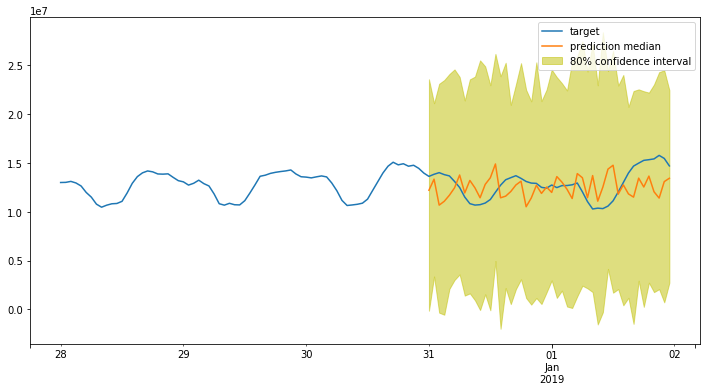

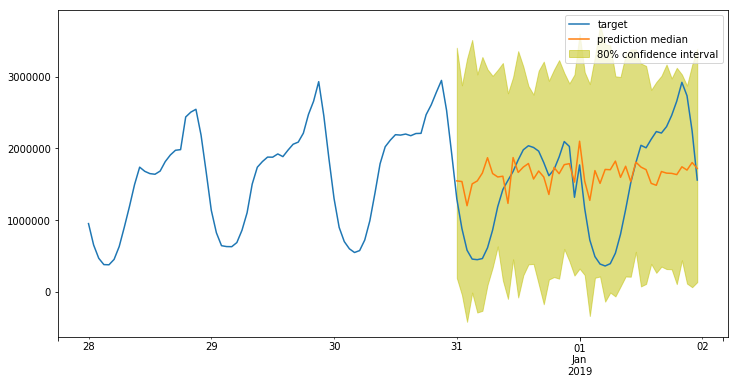

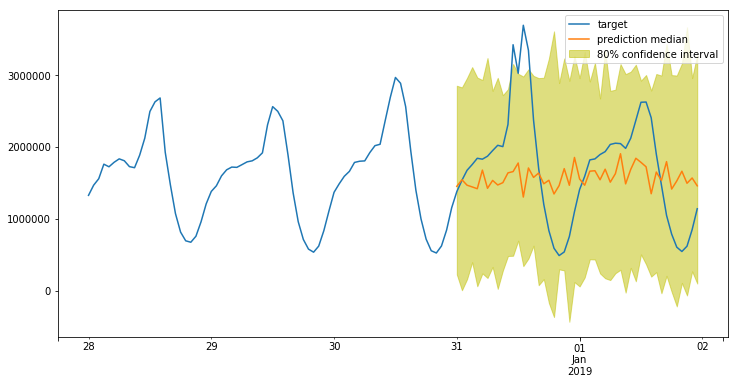

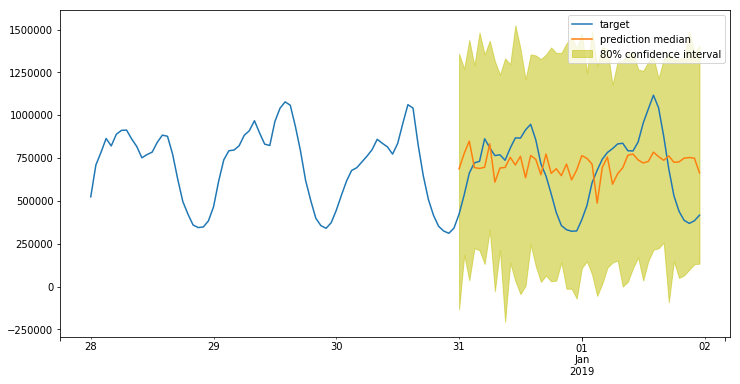

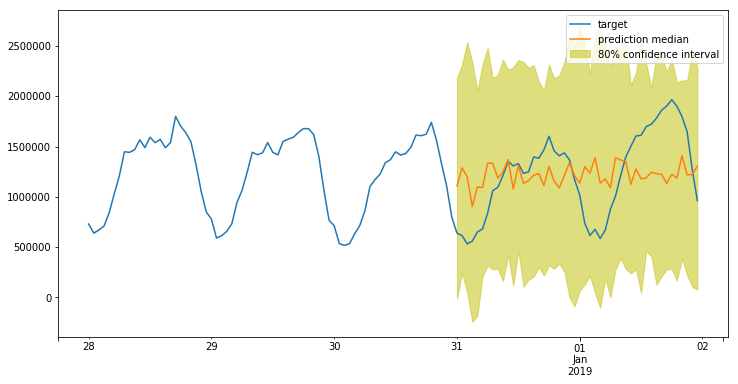

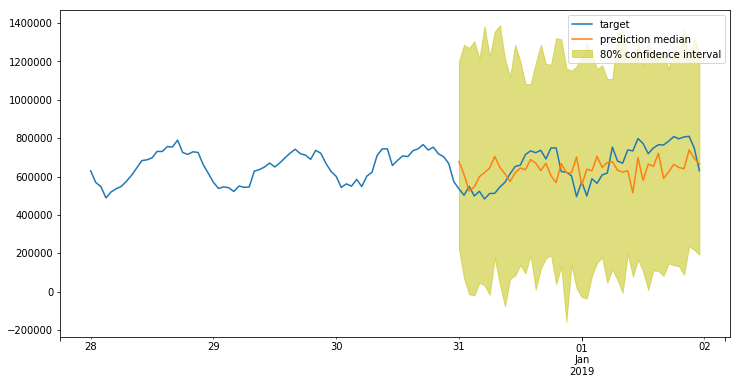

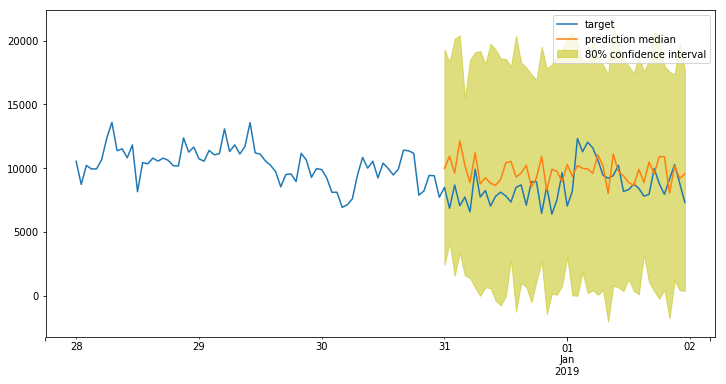

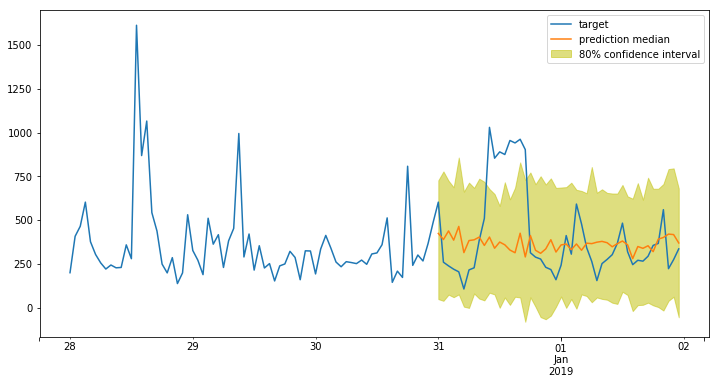

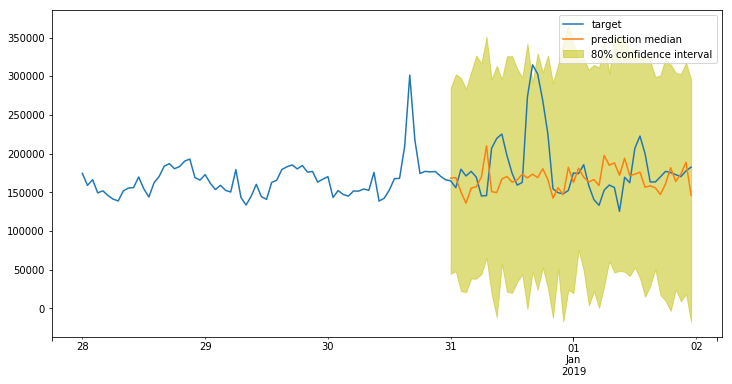

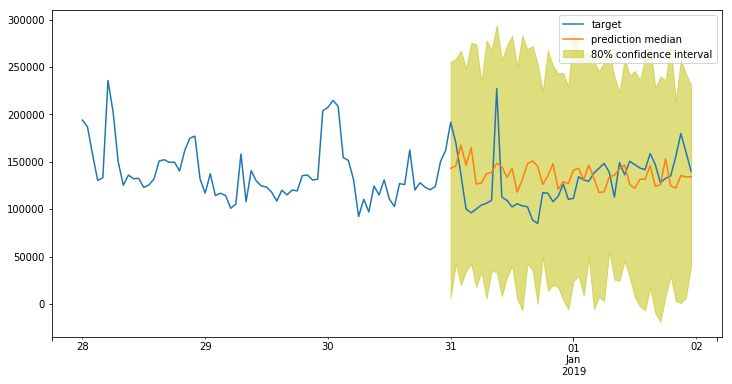

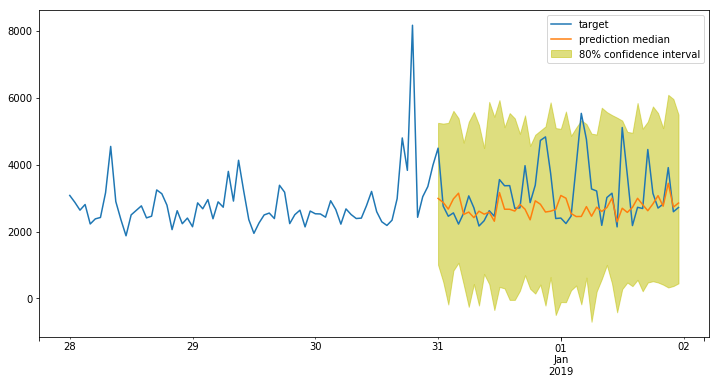

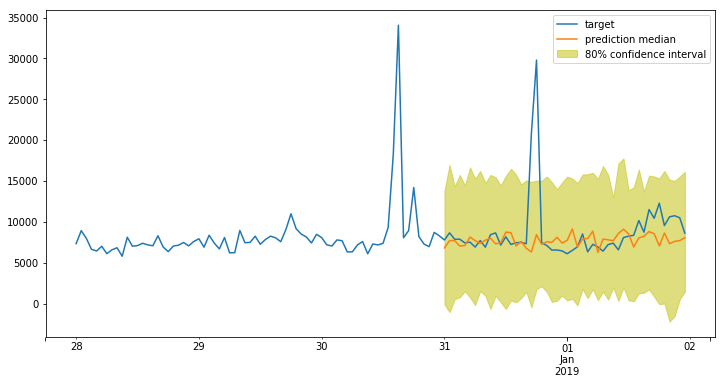

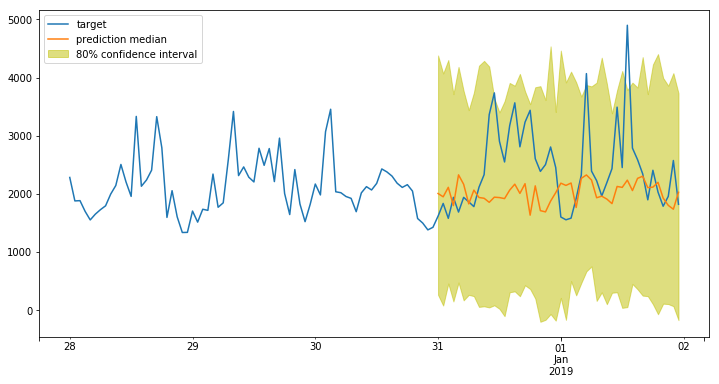

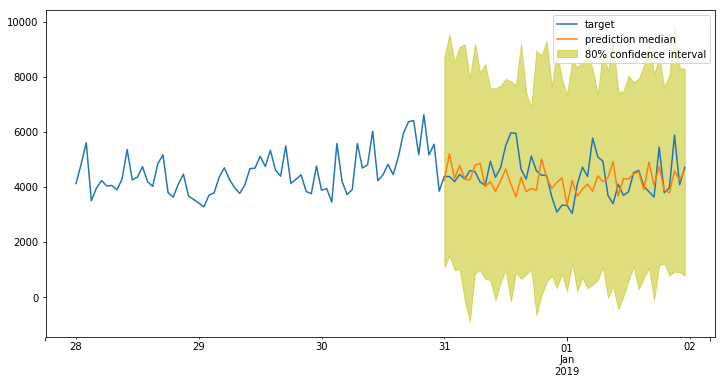

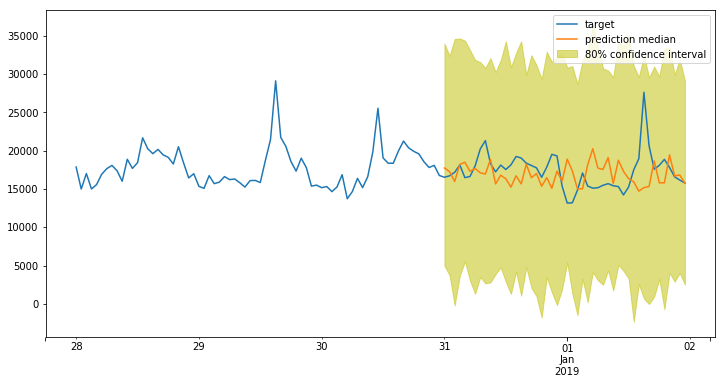

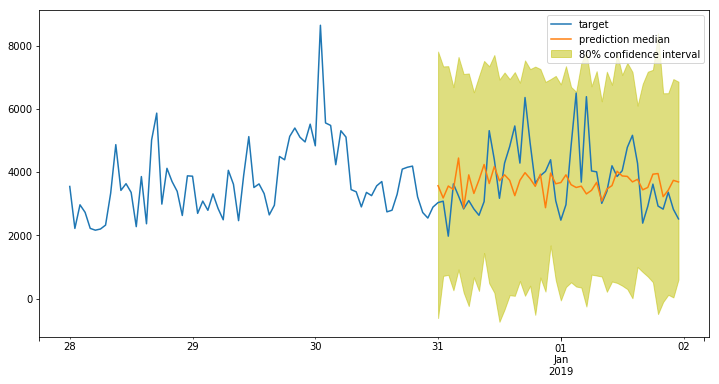

In [22]:
for k in range(len(list_of_wiki_pred)):
    plt.figure(figsize=(12,6))
    actual_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k]['0.1']
    p90 = list_of_wiki_pred[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### Metrics to evaluate the prediction
- Mean absolute percentage error
- Mean absolute error with log1p
- Symmetric mean absolute percentage error
- Symmetric mean absolute percentage error differentiable
- others?

In [23]:
# Approximated differentiable SMAPE
def differentiable_smape(true, predicted):
    epsilon = 0.1
    true_o = true
    pred_o = predicted
    summ = np.maximum(np.abs(true_o) + np.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = np.abs(pred_o - true_o) / summ
    return smape

# SMAPE, rounded up to the closest integer
def rounded_smape(true, predicted):
    true_o = np.int(np.round(true))
    pred_o = np.round(predicted).astype(np.int32)
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# SMAPE stardard definition
def smape(true, predicted):
    true_o = true
    pred_o = predicted
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# MAE standard definition
def mape(true, predicted):
    true_o = true
    pred_o = predicted
    denom = np.abs(true_o)
    mape = np.where(denom==0, 0, np.abs(pred_o - true_o) / denom)
    return mape


# MAE on log1p
def mape1p(true, predicted):
    epsilon = 0.1
    true_o = np.log1p(true + epsilon)
    pred_o = np.log1p(predicted + epsilon)
    error = np.abs(true_o - pred_o)/np.abs(true_o)
    return error

In [24]:
# input pd.series in which index = time stamps, value = time series values
# actual_series and pred_series should have exactly matched timestamps

def plot_metrics(actual_series, pred_series):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    metric_smape = differentiable_smape(actual_series.values, pred_series.values)
    metric_mape = mape(actual_series.values, pred_series.values)
    metric_maelog1p = mape1p(actual_series.values, pred_series.values)
    metric_smape_orig = smape(actual_series.values, pred_series.values)
    plt.figure(figsize=(12,6))
    plt.plot(pred_series.index, metric_smape_orig, label = 'smape standard = {}'.format(metric_smape_orig.mean()))  
    plt.plot(pred_series.index, metric_smape, label = 'smape differentialble = {}'.format(metric_smape.mean()))
    plt.plot(pred_series.index, metric_mape, label = 'mape standard = {}'.format(metric_mape.mean()))
    plt.plot(pred_series.index, metric_maelog1p, label = 'mape with log(1 + eplison +val) = {}'.format(metric_maelog1p.mean()))
    plt.xlabel('Time stamp of prediction')
    plt.ylabel('Prediction metric')
    plt.legend()
    plt.show()

### Plot the metrics for wiki data prediction

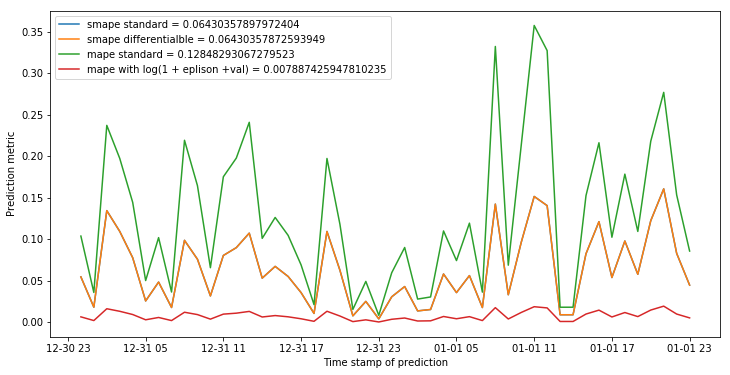

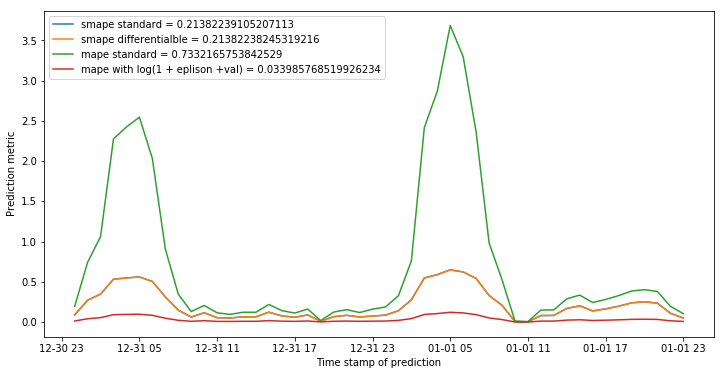

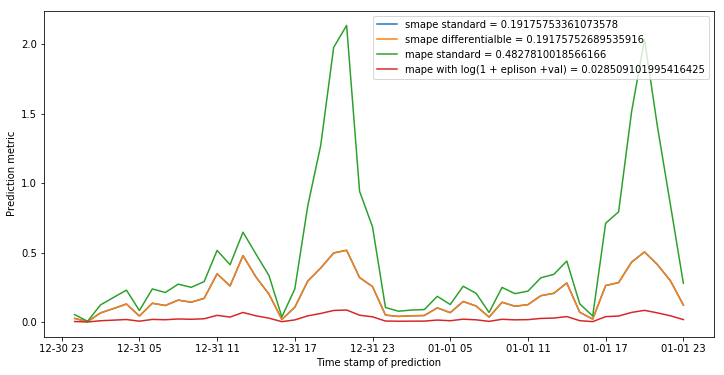

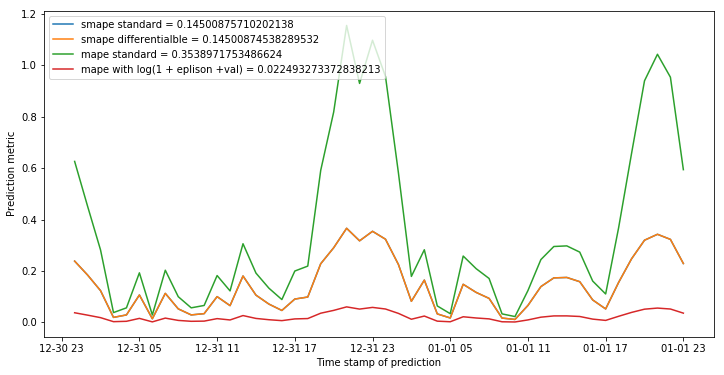

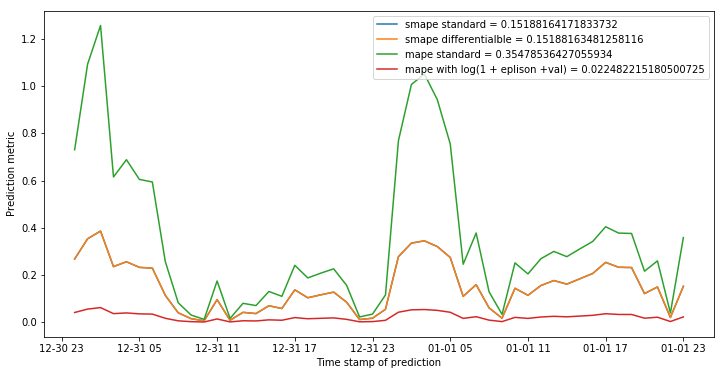

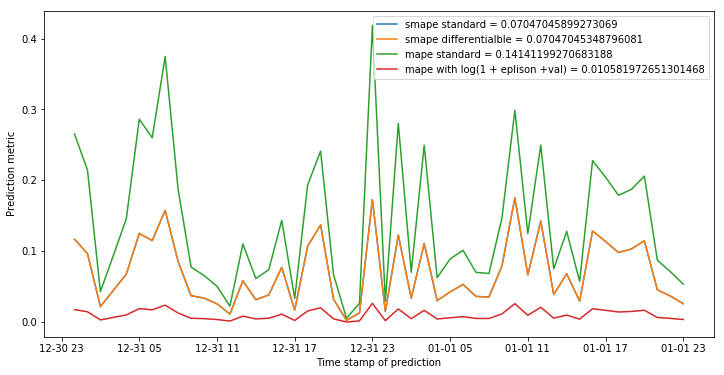

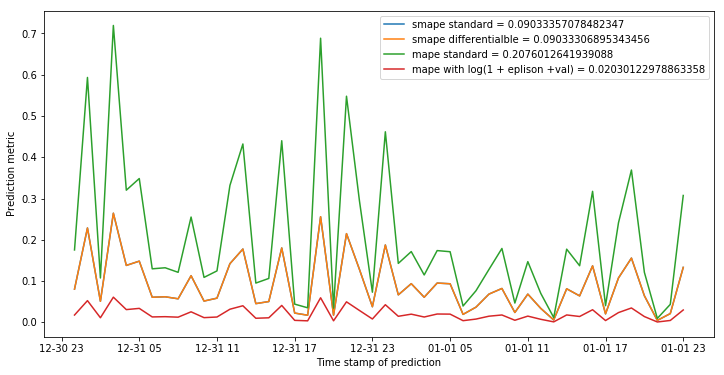

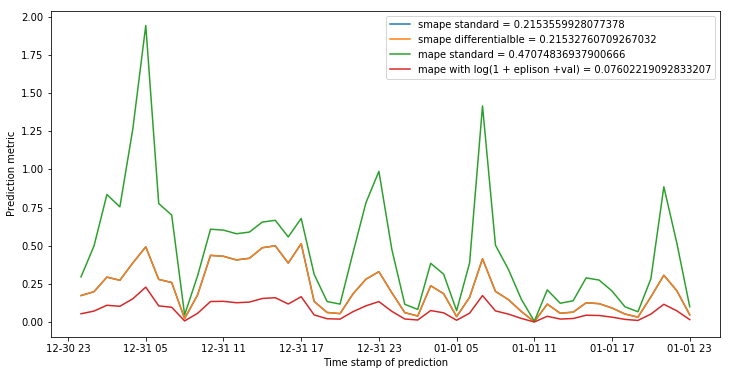

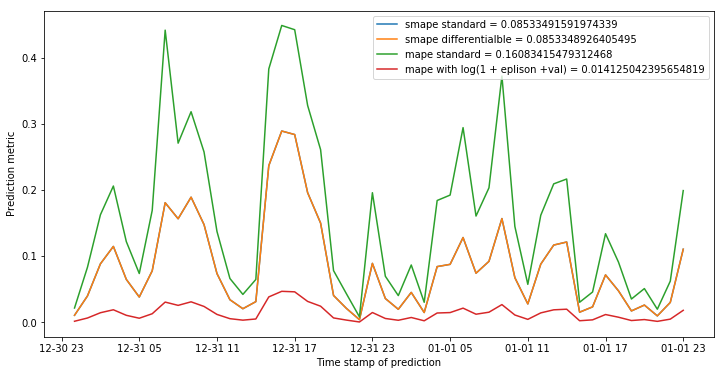

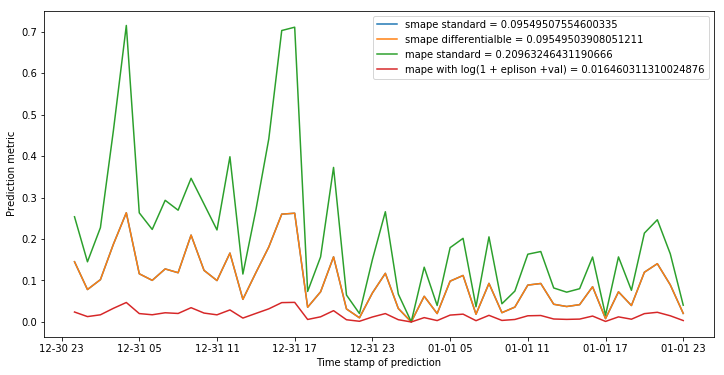

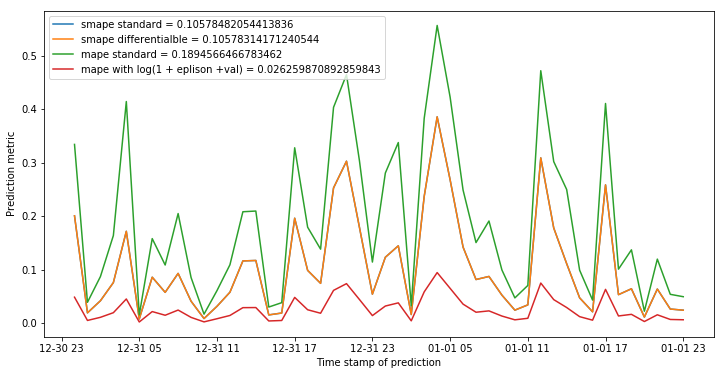

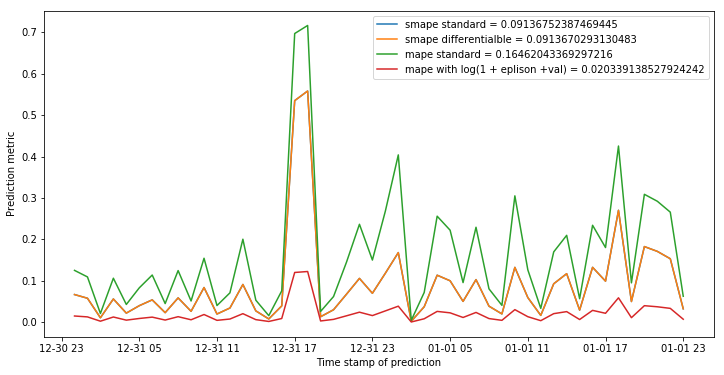

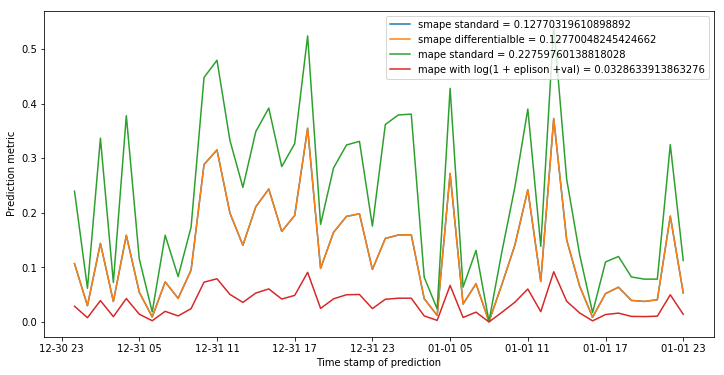

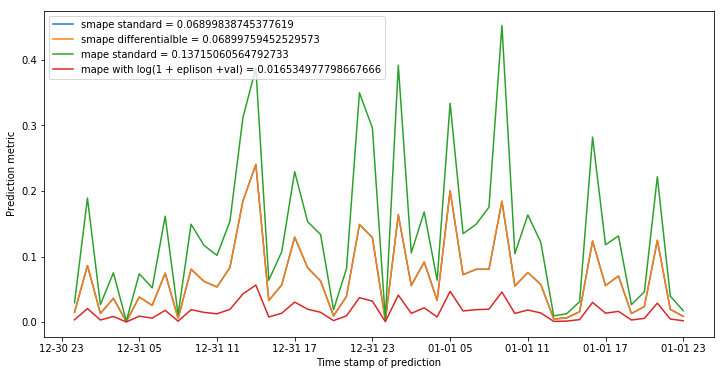

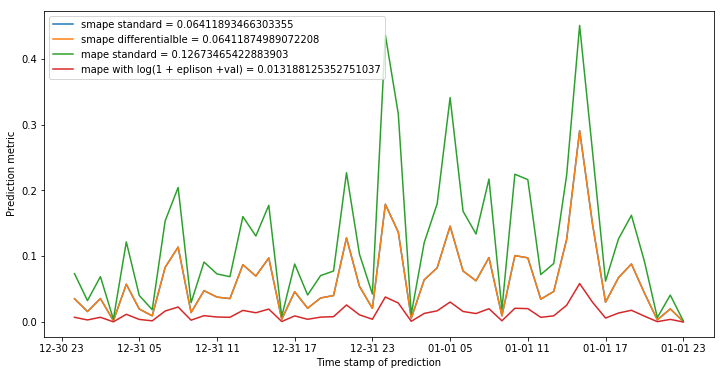

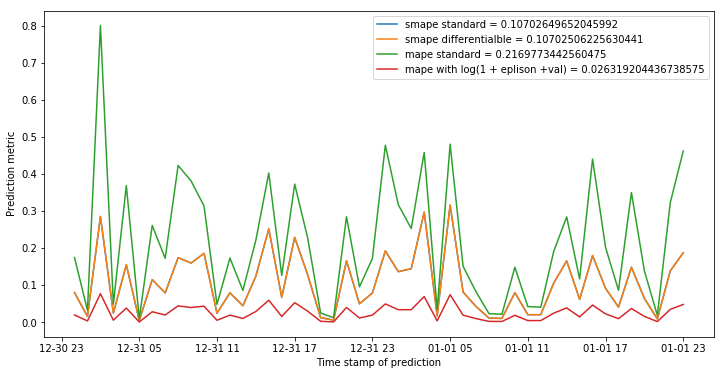

In [25]:
for k in range(len(list_of_wiki_pred)):
    plot_metrics(actual_wiki[k][-prediction_length:], list_of_wiki_pred[k]['0.5'])


In [26]:
import heapq
def characterize_ts(ts,window):
    y = ts.values # signal
    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    # we only keep the positive frequency up to the Nyquist = 1/(2*dT), dT = sampling interval
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half
    yabs = np.abs(Y)
    
    # locate the largest 15 peaks, use them to characterise the time series
    indx = heapq.nlargest(15, range(len(yabs)), yabs.__getitem__)
    amp = heapq.nlargest(15,yabs)

    mean = yabs.mean()
    std = yabs.std()
    cyc_hday = 2.0
    cyc_day = cyc_hday / 2.0
    cyc_week = cyc_day / 7.0
    cyc_month = cyc_day / 30.0

    comp = lambda a,b : np.abs(a/b - 1) < 0.05
    ts_type = ['trend', 'halfDay', 'Day', 'Week', 'Month', 'spike']
    report_list = [0] * 8
    for counter, value in enumerate(indx):
        # define a peak in frequency domain
        if amp[counter] > (mean + 3*std):
            amp_norm = (amp[counter] - mean)/std
            if cycle[value] < 0.01:
                # trend (increasing, decreasing, gaussian pulse)
                report_list[0] = max(amp_norm,report_list[0])
            elif comp(cycle[value], cyc_hday):
                report_list[1] = max(amp_norm,report_list[1])
            elif comp(cycle[value], cyc_day):
                report_list[2] = max(amp_norm,report_list[2])
            elif comp(cycle[value], cyc_week):
                report_list[3] = max(amp_norm,report_list[3])
            elif comp(cycle[value], cyc_week):
                report_list[4] = max(amp_norm,report_list[4])

    if sum(report_list[:4]) > 0:
        index = report_list[:4].index(max(report_list[:4])) 
        report_list[5] = ts_type[index]
    else: 
        report_list[5] = ts_type[-1:]

    report_list[-2] = y.mean()
    report_list[-1] = y.std()
    return report_list

In [27]:
character_list = []
day = 24
for item in time_series_wiki:
    character_list.append(characterize_ts(item,day))

In [28]:
error_list = []
for i in range(len(list_of_wiki_pred)):
    metric_smape = differentiable_smape(actual_wiki[i][-prediction_length:].values, list_of_wiki_pred[i]['0.5'].values)
    error_list.append(metric_smape.mean())

In [29]:
ans = {}
# We have ['trend', 'halfDay', 'Day', 'Week', 'Month', 'spike'].
ans['trend'] = []
ans['halfDay'] = []
ans['Day'] = []
ans['Week'] = []
ans['Month'] = []
ans['spike'] = []

for i in range(len(error_list)):
    ans[character_list[i][5]].append(error_list[i])

for key, value in ans.items():
    if value:
        print(key, ' smape ', np.mean(value), ' number of series ', len(value))


trend  smape  0.10734975280873772  number of series  9
Day  smape  0.13179703062835393  number of series  7


### Delete endpoint

In [30]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2019-01-28-05-34-26-468
